In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
model = pybamm.lithium_ion.DFN(options={
    "SEI": "constant",
    "SEI porosity change": "true",
    #"SEI on cracks": "true",
    #"particle mechanics": "constant cracks",
    "contact resistance": "true",
})

param = pybamm.ParameterValues("OKane2023")

exp = pybamm.Experiment(
    [("Discharge at 2C for 72 seconds or until 2.5V", )] * 1,
)

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 30,  # positive particle
}

sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve()

In [14]:
import matplotlib as mpl; 
fs = 18
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)

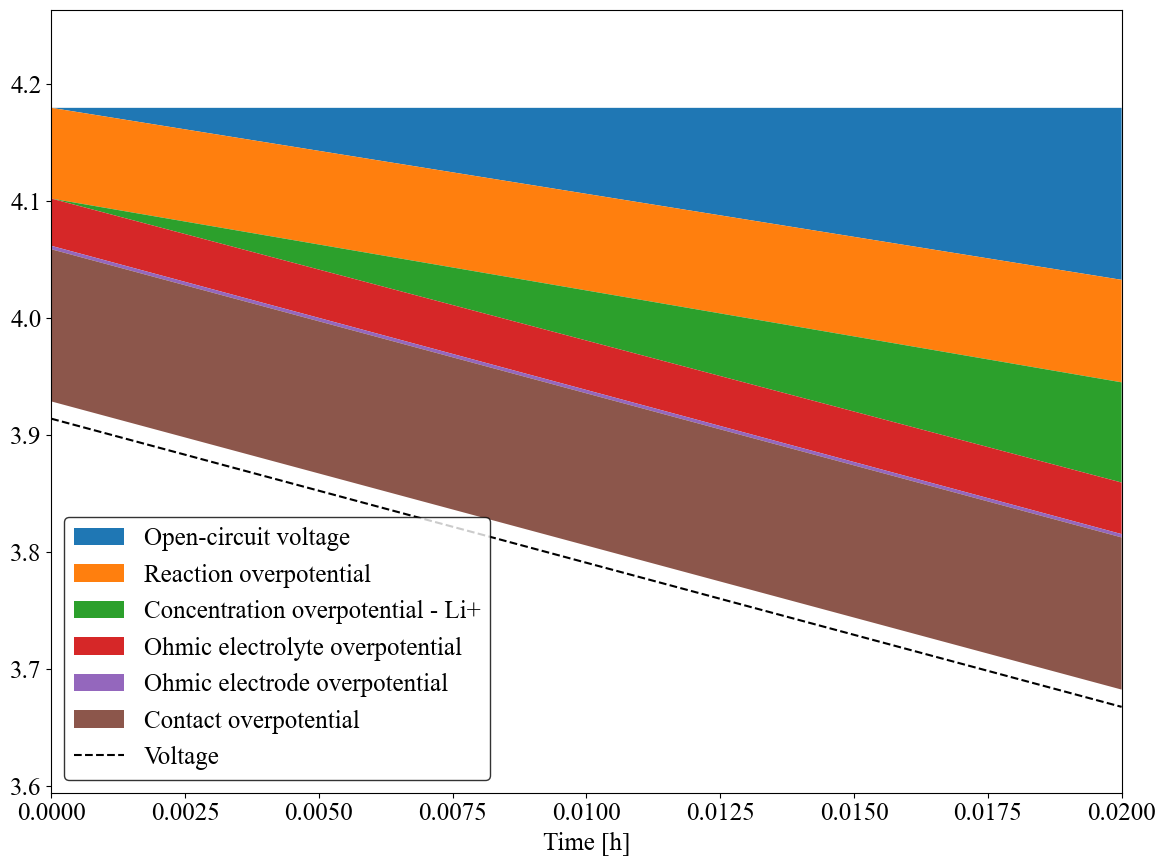

In [15]:
show_legend = True
fig, ax = plt.subplots(figsize=(12,9),tight_layout=True)
overpotentials = [
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    #"X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
    "Contact overpotential [V]",
]
labels = [
    "Reaction overpotential",
    "Concentration overpotential - Li+",
    #"Concentration overpotential - EC",
    "Ohmic electrolyte overpotential",
    "Ohmic electrode overpotential",
    "Contact overpotential",
]

# Plot
# Initialise
solution = sol
time = solution["Time [h]"].entries # 
initial_ocv = solution["X-averaged battery open circuit voltage [V]"].entries[0]
ocv = solution["X-averaged battery open circuit voltage [V]"].entries
ax.fill_between(time, ocv, initial_ocv,  label="Open-circuit voltage")
top = ocv
# Plot components
for overpotential, label in zip(overpotentials, labels):
    if overpotential == "Contact overpotential [V]":
        bottom = top - solution[overpotential].entries
    else:
        bottom = top + solution[overpotential].entries
    ax.fill_between(time, bottom, top,   label=label)
    top = bottom

V = solution["Terminal voltage [V]"].entries
ax.plot(time, V, "k--", label="Voltage")

if show_legend:
    leg = ax.legend(loc="lower left", frameon=True)
    leg.get_frame().set_edgecolor("k")

# Labels
ax.set_xlim([time[0], time[-1]])
ax.set_xlabel("Time [h]")

y_min, y_max = 0.98 * min(np.nanmin(V), np.nanmin(ocv)), 1.02 * (
    max(np.nanmax(V), np.nanmax(ocv))
)
ax.set_ylim([y_min, y_max])
plt.show()

Text(0.5, 1.0, 'Potential error')

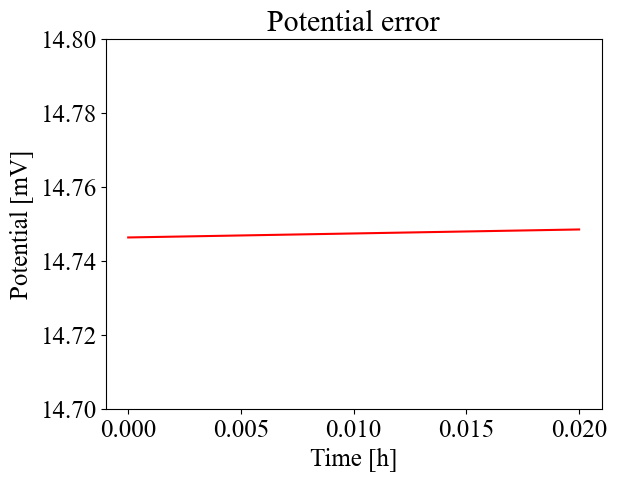

In [23]:
plt.plot(time, (bottom-V)*1e3, "r-", label="Voltage")
plt.ylabel("Potential [mV]",   fontdict={'family':'Times New Roman','size':fs})
plt.xlabel('Time [h]',   fontdict={'family':'Times New Roman','size':fs})
plt.ylim(1.47e1,1.48e1)
plt.title("Potential error")